## CHEMMA example application at Panola Research Watershed
### Arthor: Xu Fei, Esther (https://orcid.org/0000-0002-2716-2339)
### Last Update: 10/21/2020

First, import all required packages. You might need to install some of the packages.

In [1]:
# ==============================================================================
# basic math packages
import numpy as np
import pandas as pd
from itertools import combinations
# ==============================================================================
# plot making packages
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D # This is for making 3D axis
# ==============================================================================
# dimension analysis packages
from sklearn.decomposition import FactorAnalysis, KernelPCA
from sklearn.model_selection import cross_val_score
# ==============================================================================
# CHEMMA core algorithm related packages
from pymf.chnmf import * # This is the package for CH-NMF
from copkmeans.cop_kmeans import cop_kmeans # This is the package for COP-KMEANS

Second, I defined several basic functions:
    1. do_PCAEMMA: perform PCA EMMA plus the PC2 vs. PC1 subspace plot
        input: data = observed chemical composition; n samples * m attributes
               end_members = end-member chemical composition; n end-members * m attributes
        output: X = normalized data; n samples * m attributes
                P = projection matrix; m attributes * m PCs
                mean = mean of the original data
                std = st.dev of the original data
                Yem = projected end-members
    2. do_CHNMF: perform one CH-NMF run, first step of CHEMMA
        input: data = observed chemical composition; n samples * m attributes
               P = projection matrix; m attributes * m PCs
               num_of_bases = desired number of end-members
        output: proj = end-member composition in PC space
                rec.values = end-member composition in observational space
                dfW = projection matrix
    3. twoD_obs_proj: make the base plot for projecting observations into PC2 vs. PC1 subspace
        input: X = normalized data; n samples * m attributes
               P = projection matrix; m attributes * m PCs
               num_of_bases = desired number of end-members
        output: a plot

In [2]:
def do_PCAEMMA(data, end_members):
    data_norm = ((data-data.mean())/data.std())
    print data_norm.describe()
    end_members_norm = ((end_members-data.mean())/data.std())
    print end_members_norm.describe()
    mean = data.mean()
    std = data.std()
    X = data_norm.values
    n = X.shape[0]
    p = X.shape[1]
    print "X represents {n} samples (in rows) of {p} parameters (in columns)".format(n=n, p=p)
    Sx = np.dot(X.T, X) / (n - 1)
    print pd.DataFrame(Sx, index=data.columns, columns=data.columns)
    eig_vals, eig_vecs = np.linalg.eig(Sx)
    print "The eigenvalues are arranged from largest to smallest:"
    print eig_vals
    Lambda = eig_vals
    pct_var = (Lambda / np.sum(Lambda) * 100).real
    P = eig_vecs.T
    Y = np.dot(X, P.T)
    Yd = pd.DataFrame(Y)
    Yd.columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6"]
    Xem = end_members_norm.values
    Yem = np.dot(Xem, P.T)
    print pd.DataFrame(Yem, index=end_members.index)
    N_em = len(end_members)
    Pfv = np.vstack([np.ones((1, N_em)), Yem[:, :N_em - 1].T])
    Pvf = np.linalg.inv(Pfv)
    print Pvf
    Yf = np.vstack((np.ones((1, n)), Y[:, :(N_em - 1)].T)).T
    f_unc = np.dot(Pvf, Yf.T).T
    # plot section
    plt.rcParams['figure.figsize'] = (8, 8)
    scale_val = 5
    cmap = plt.cm.jet
    import matplotlib.colors as colors
    cNorm = colors.Normalize(vmin=-(p - 1), vmax=0)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    plt.plot(Y[:, 0], Y[:, 1], marker='.', color='0.5', linestyle='', label='Field samples - Streamwater')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.plot(Yem[:, 0], Yem[:, 1], marker='o', color='0.3', linestyle='')
    for em in range(N_em):
        plt.plot(Yem[em, 0], Yem[em, 1], marker=em_marker[end_members.index[em]],
                 color='0.3', linestyle='', markersize=10, label=end_members.index[em])
    plt.fill(Yem[:, 0], Yem[:, 1], fill=False, color='0.3')
    E = np.dot(P, np.eye(p).T).T

    for pi in range(p):
        colorVal = scalarMap.to_rgba(-pi)
        plt.plot([0, E[pi, 0] * scale_val], [0, E[pi, 1] * scale_val],
                 linewidth=3, color=colorVal, label=data.columns[pi])
    plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)
    plt.title('Data displayed in the Principal Components subspace')
    return X,P,mean,std,Yem
def do_CHNMF(data, P, num_of_bases):
    data_norm = ((data - data.mean()) / data.std())
    X = data_norm.values
    ch = CHNMF(X.T, num_bases = num_of_bases)
    ch.factorize()
    dfW = pd.DataFrame(ch.W) # transfer matrix
    #dfH = pd.DataFrame(ch.H) # contribution
    dfW.index = data.columns
    proj = np.dot(dfW.T, P.T)
    mean = data.mean()
    std = data.std()
    rec = dfW.T * std + mean
    return proj,rec.values,dfW
def twoD_obs_proj(X,P, end_members):
    end_members_norm = ((end_members-data.mean())/data.std())
    Y = np.dot(X, P.T)
    Yd = pd.DataFrame(Y)
    Yd.columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6"]
    Xem = end_members_norm.values
    Yem = np.dot(Xem, P.T)
    N_em = len(end_members)
    Pfv = np.vstack([np.ones((1, N_em)), Yem[:, :N_em - 1].T])
    Pvf = np.linalg.inv(Pfv)
    Yf = np.vstack((np.ones((1, n)), Y[:, :(N_em - 1)].T)).T
    f_unc = np.dot(Pvf, Yf.T).T
    # plot section
    plt.rcParams['figure.figsize'] = (8, 8)
    scale_val = 5
    cmap = plt.cm.jet
    import matplotlib.colors as colors
    cNorm = colors.Normalize(vmin=-(p - 1), vmax=0)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    plt.plot(Y[:, 0], Y[:, 1], marker='.', color='0.5', linestyle='', label='Field samples - Streamwater')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.plot(Yem[:, 0], Yem[:, 1], marker='o', color='0.3', linestyle='')
    E = np.dot(P, np.eye(p).T).T
    for em in range(N_em):
        plt.plot(Yem[em, 0], Yem[em, 1], marker=em_marker[end_members.index[em]],
                 color='0.3', linestyle='', markersize=10, label=end_members.index[em])
    plt.fill(Yem[:, 0], Yem[:, 1], fill=False, color='0.3')
    E = np.dot(P, np.eye(p).T).T
    plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)
    plt.title('Data displayed in the Principal Components subspace')
    return

Next, load the observation and the end-member chemical compositions.

In [3]:
# Load the streamwater samples
data = pd.read_csv("panola_data.csv")
print data.describe()
# Load the end members
end_members = pd.read_csv("panola_end_members.csv", index_col='End member')
print end_members
N_em = len(end_members)
# Define a marker for each end member (for plotting later)
em_marker = {'Field sample - Organic':'*', 'Field sample - Hillslope':'^', 'Field sample - Groundwater':'o'}
end_members.index = ['Field sample - Organic', 'Field sample - Hillslope', 'Field sample - Groundwater']

              Alk         SO4          Na          Mg          Ca          Si
count  905.000000  905.000000  905.000000  905.000000  905.000000  905.000000
mean   140.143867   64.866042  105.188999   55.176796   90.320279  214.463404
std     99.505976   34.228440   43.738778   17.387645   29.914713  100.053530
min     -6.000000    1.699973   25.218400   27.159000   35.913600   42.731520
25%     49.000000   33.957457   67.828800   40.327000   66.839200  129.792000
50%    122.000000   69.998880   99.103964   51.849000   83.299600  199.680000
75%    212.000000   90.831547  138.305532   68.341920  109.237200  290.651213
max    363.100000  223.996416  261.314800  106.957080  199.021200  472.542720
             Alk  SO4   Na  Mg   Ca   Si
End member                              
Organic       37  214   23  78  151   60
Hillslope      9   89   46  22   32   90
Groundwater  370    7  169  97  162  422


The next code section generates the result of ONE random run of CH-NMF. It only run CH-NMF ONE time for 3 or 4 end-member case each. Then it plots Ch-NMF predicted end-members in the PC subspace to compare with the individual end-member samples.

                Alk           SO4            Na            Mg            Ca  \
count  9.050000e+02  9.050000e+02  9.050000e+02  9.050000e+02  9.050000e+02   
mean  -2.208178e-18  1.490030e-15  1.211063e-15 -2.676312e-15 -5.709368e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.468694e+00 -1.845426e+00 -1.828368e+00 -1.611362e+00 -1.818726e+00   
25%   -9.159638e-01 -9.030089e-01 -8.541665e-01 -8.540429e-01 -7.849341e-01   
50%   -1.823395e-01  1.499583e-01 -1.391222e-01 -1.913885e-01 -2.346898e-01   
75%    7.221288e-01  7.585944e-01  7.571435e-01  7.571539e-01  6.323618e-01   
max    2.240631e+00  4.649069e+00  3.569505e+00  2.977993e+00  3.633694e+00   

                 Si  
count  9.050000e+02  
mean   1.542781e-15  
std    1.000000e+00  
min   -1.716400e+00  
25%   -8.462610e-01  
50%   -1.477549e-01  
75%    7.614705e-01  
max    2.579412e+00  
            Alk       SO4        Na        Mg        Ca        Si
count  3.000000  3.00000

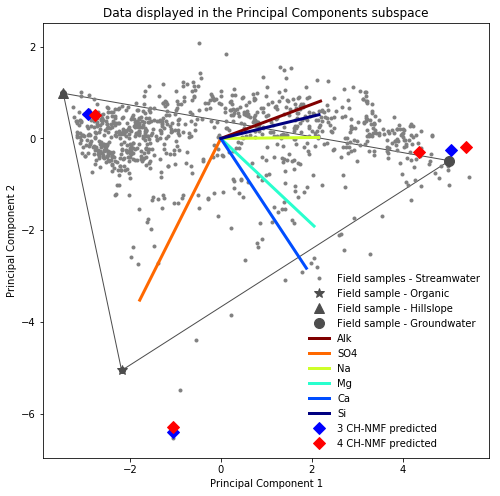

In [7]:
# Perform PCA EMMA, and make a base plot in the PC subspace
[X,P,mean,std,Yem] = do_PCAEMMA(data, end_members)
n = X.shape[0]
p = X.shape[1]
# Perform CH-NMF for 3 and 4 end-member cases, and plot them onto the PC space
[proj3,W3,dfW3] = do_CHNMF(data, P, num_of_bases = 3)
[proj4,W4,dfW4] = do_CHNMF(data, P, num_of_bases = 4)
plt.plot(proj3[:, 0], proj3[:, 1], "bD", markersize=8,label = "3 CH-NMF predicted")
plt.plot(proj4[:, 0], proj4[:, 1], "rD", markersize=8, label = "4 CH-NMF predicted")
plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)

The following section generates 100 CH-NMF runs and use COP-Kmeans to group those runs for FOUR end-members. It is used to make plots like Figure 3 b and d.
    1. do_CHEMMA: perform CHEMMA algorithm
        input: data = observed chemical composition; n samples * m attributes
               P = projection matrix; m attributes * m PCs
               n_comp = number of end-member components
               it = the number of CH-NMF runs
        output: input_matrix = end-members projected in PC space; it samples * m attributes
                obs_matrix = end-members in observation space; it samples * m attributes
                clusters = the cluster label for each end-member; it samples * 1
                centers = the cluster center coordinates; n_components * m attributes
    2. CHEMMA_2Dplot: make 2D projection plot in PC2 vs. PC1
        input: input_matrix = end-members projected in PC space; it samples * m attributes
               clusters = the cluster label for each end-member; it samples * 1
        output: a plot
    3. CHEMMA_3Dplot: make 3D projection plot in PC3 vs. PC2 vs. PC1
        input: input_matrix = end-members projected in PC space; it samples * m attributes
               clusters = the cluster label for each end-member; it samples * 1
               Yem = end-member projected in PC space
        output: a plot

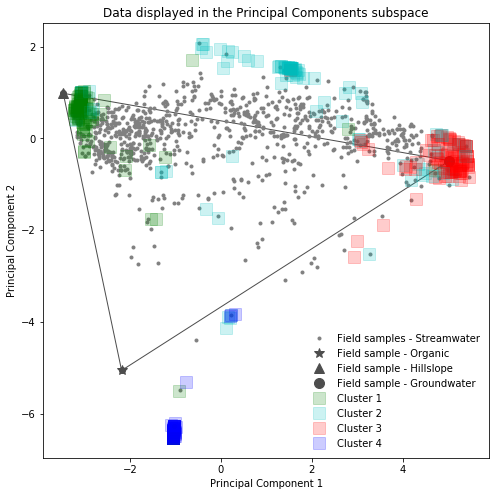

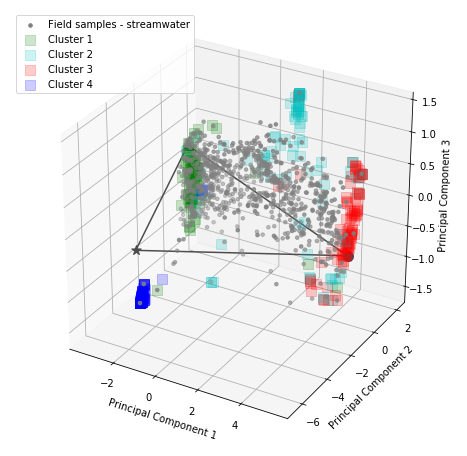

In [8]:
def do_CHEMMA(data,P,n_comp,it = 100):
    store = []
    rec = []
    for i in range(it):
        [proj,reco,dfW] = do_CHNMF(data, P, num_of_bases=4)
        store.append(proj)
        rec.append(reco)
    input_matrix = np.array(store).transpose(2,0,1).reshape(6,-1).T
    obs_matrix = np.array(rec).transpose(2,0,1).reshape(6,-1).T
    cl = np.zeros((n_comp, it))
    for j in range(n_comp):
        for i in range(it):
            cl[j,i] = n_comp * i + j
    cl = cl.astype(int)
    must_link = []
    cannot_link = []
    com =list(combinations(np.arange(n_comp),2))
    for j in range(len(com)):
        cannot_link += zip(cl[com[j][0]],cl[com[j][1]])
    clusters, centers = cop_kmeans(dataset=input_matrix, k=4, ml=must_link,cl=cannot_link)
    return input_matrix,obs_matrix,clusters,centers

def CHEMMA_2Dplot(input_matrix,clusters):
    color = np.array(clusters).astype(str)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(np.amax(clusters)+1):
        color[color == str(i)] = colors[i]
    twoD_obs_proj(X,P, end_members)
    for i in range(len(color)-4):
        plt.plot(input_matrix[i, 0], input_matrix[i, 1], color[i] + 's', markersize=12, alpha = 0.2)
    for i in range(len(color)-4,len(color)):
        plt.plot(input_matrix[i, 0], input_matrix[i, 1],  color[i] + 's', markersize=12, alpha = 0.2, label='Cluster {}'.format(i - len(color) + 5))
    # -----for control cluster color------------------------------------
    # plt.plot(input_matrix[len(color)-1, 0], input_matrix[len(color)-1, 1],  color[len(color)-1] + 's', markersize=12, alpha = 0.2, label='Cluster 1')
    # plt.plot(input_matrix[len(color)-3, 0], input_matrix[len(color)-3, 1],  color[len(color)-3] + 's', markersize=12, alpha = 0.2, label='Cluster 2')
    # plt.plot(input_matrix[len(color)-2, 0], input_matrix[len(color)-2, 1],  color[len(color)-2] + 's', markersize=12, alpha = 0.2, label='Cluster 3')
    # plt.plot(input_matrix[len(color)-4, 0], input_matrix[len(color)-4, 1],  color[len(color)-4] + 's', markersize=12, alpha = 0.2, label='Cluster 4')
    plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)
    return
def CHEMMA_3Dplot(input_matrix,clusters,Yem):
    color = np.array(clusters).astype(str)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(np.amax(clusters)+1):
        color[color == str(i)] = colors[i]
    # 3-D projection
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    Y = np.dot(X, P.T)
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], s=50, marker='.', color='0.5', label='Field samples - streamwater')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    # ax.scatter3D(proj4[:, 0], proj4[:, 1], proj4[:, 2], s = 100, marker = "*", color = 'blue', label='EMs')
    for i in range(len(color)-4):
        ax.scatter3D(input_matrix[i, 0], input_matrix[i, 1], input_matrix[i, 2], s=100, marker="s", color=color[i], alpha = 0.2)
    for i in range(len(color)-4,len(color)):
        ax.scatter3D(input_matrix[i, 0], input_matrix[i, 1], input_matrix[i, 2], s=100, marker="s", color=color[i], label='Cluster {}'.format(i - len(color) + 5),alpha = 0.2)
        #ax.scatter3D(input_matrix[i, 0], input_matrix[i, 1], input_matrix[i, 2], s=100, marker="s", color=color[i], alpha=0.2)
    # -----for control cluster color------------------------------------
    # ax.scatter3D(input_matrix[len(color)-1, 0], input_matrix[len(color)-1, 1], input_matrix[len(color)-1, 2], s=100, marker="s", color= color[len(color)-1], alpha = 0.2, label='Cluster 1')
    # ax.scatter3D(input_matrix[len(color)-4, 0], input_matrix[len(color)-4, 1], input_matrix[len(color)-4, 2], s=100, marker="s", color= color[len(color)-4], alpha = 0.2, label='Cluster 2')
    # ax.scatter3D(input_matrix[len(color)-2, 0], input_matrix[len(color)-2, 1], input_matrix[len(color)-2, 2], s=100, marker="s", color= color[len(color)-2], alpha = 0.2, label='Cluster 3')
    # ax.scatter3D(input_matrix[len(color)-3, 0], input_matrix[len(color)-3, 1], input_matrix[len(color)-3, 2], s=100, marker="s", color= color[len(color)-3], alpha = 0.2, label='Cluster 4')

    plt.legend(loc='upper left', numpoints=1, fontsize=10)
    for em in range(N_em):
        ax.scatter3D(Yem[em, 0], Yem[em, 1], Yem[em, 2], s=100, marker=em_marker[end_members.index[em]], color='0.3',
                     label=end_members.index[em])
    YY = np.append(Yem, Yem[0]).reshape(4, -1)

    ax.plot(YY[:, 0], YY[:, 1], YY[:, 2], color='0.3')
    return


# ======================================
# actual CHEMMA run
# ======================================
n_comp = 4
[input_matrix,obs_matrix,clusters,centers] = do_CHEMMA(data,P,n_comp =n_comp,it = 100)
# make plots
CHEMMA_2Dplot(input_matrix,clusters)
CHEMMA_3Dplot(input_matrix,clusters,Yem)

The following cell reproduce the result of Figure 2.

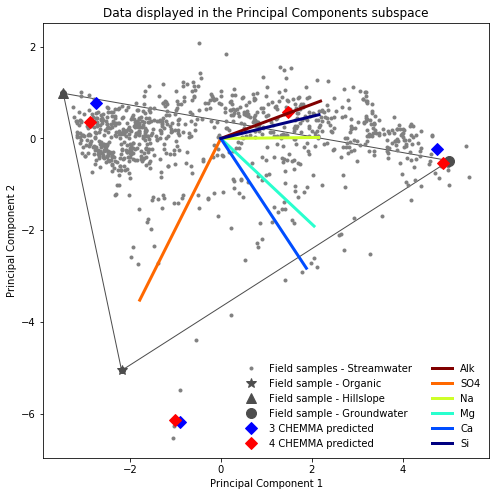

In [9]:
# load the base plot
twoD_obs_proj(X,P, end_members)
# load the data centroids for 3 EMs and 4 EMs cases
proj3 = pd.read_csv("3EM_centers.csv", header = None)
proj4 = pd.read_csv("4EM_centers.csv", header = None)
plt.plot(proj3.values[:, 0], proj3.values[:, 1], "bD", markersize=8,label = "3 CHEMMA predicted")
plt.plot(proj4.values[:, 0], proj4.values[:, 1], "rD", markersize=8, label = "4 CHEMMA predicted")
# load the axis
p = X.shape[1]
E = np.dot(P, np.eye(p).T).T
scale_val = 5
cmap = plt.cm.jet
import matplotlib.colors as colors
cNorm = colors.Normalize(vmin=-(p - 1), vmax=0)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
for pi in range(p):
    colorVal = scalarMap.to_rgba(-pi)
    plt.plot([0, E[pi, 0] * scale_val], [0, E[pi, 1] * scale_val],
                 linewidth=3, color=colorVal, label=data.columns[pi])
plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10,ncol = 2)

The following section calculates the means and standard deviation (st.dev) for the six measured solutes within clusters, and save calculation into files

In [10]:
# ====================================================================
# calculate stats
def cal_stats_clusters(input_matrix,clusters):
    n_comp = np.amax(clusters)+1
    n_dim = input_matrix.shape[1]
    cc = np.array(clusters)
    mean = np.zeros((n_comp,n_dim))
    sd = np.zeros((n_comp,n_dim))
    for j in range(n_comp):
        mean[j] = np.mean(input_matrix[cc == j], axis=0)
        sd[j] = np.std(input_matrix[cc == j], axis=0)
    return mean,sd


[mean_i,sd_i] = cal_stats_clusters(input_matrix,clusters)
[mean_o,sd_o] = cal_stats_clusters(obs_matrix,clusters)

# ====================================================================
# save files
def save_files(folder_name,input_matrix,clusters,centers,mean_i,mean_o,sd_i,sd_o):
    n_comp = np.amax(clusters) + 1
    np.savetxt(folder_name + str(n_comp) + 'EM.csv', input_matrix, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_cluster.csv', clusters, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_centers.csv', centers, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_obs_mean.csv', mean_i, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_obs_var.csv', sd_i, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_obs_mean.csv', mean_o, delimiter=',')
    np.savetxt(folder_name + str(n_comp) + 'EM_obs_var.csv', sd_o, delimiter=',')
    return

folder_name = "~\\save\\"
save_files(folder_name,input_matrix,clusters,centers,mean_i,mean_o,sd_i,sd_o)


In PC space, the means are:
 [[ 0.60763827 -1.28910324 -0.10974235 -0.0741662   0.05693087  0.07032869]
 [ 0.56458708 -1.4124881  -0.11185276 -0.07886736  0.06832639  0.1192262 ]
 [ 0.72821735 -1.77270691 -0.17767015 -0.12448517  0.08589338  0.05890727]
 [ 0.99805479 -1.31845624 -0.15700428 -0.0831253   0.04184748  0.0162201 ]] 
 and the st.dev are:
 [[3.26993587 2.87600771 0.6837462  0.49543346 0.21066777 0.49274812]
 [3.01325325 3.06750975 0.75917753 0.47313699 0.2371328  0.60416815]
 [3.06002314 3.17745399 0.71374228 0.5101341  0.24152835 0.54426286]
 [3.19850647 2.82412892 0.68194809 0.49841506 0.23552502 0.5343563 ]]
In obervational space, the means are: 
[[151.42919239  87.3263138  110.5056128   68.12258905 120.66985911
  226.67577509]
 [148.21739567  91.05345141 108.23610096  68.45772718 122.47673297
  227.04484716]
 [152.31414546  96.50472359 110.33950699  72.5120132  130.98113436
  222.21306266]
 [167.37168117  82.12532747 118.24933233  71.3169649  126.17370818
  237.19401112]

The following section perform dimension analysis on original stream water data.

D:\Anaconda22222\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<Figure size 576x576 with 0 Axes>

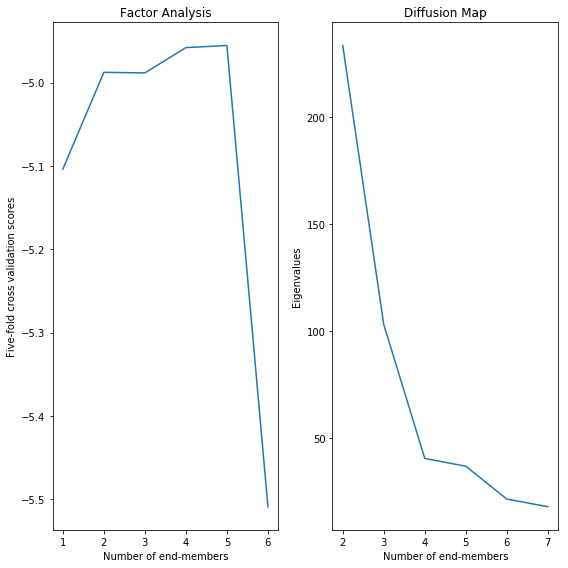

In [10]:
# ==============================
# for CV data analysis part
# ==============================
score_c = []
for n_comp in range(6):
    fa = FactorAnalysis(n_components=n_comp + 1)
    score_c.append(np.mean(cross_val_score(fa,X)))
score_c = np.array(score_c)
plt.figure()
fig,ax = plt.subplots(1,2)
ax[0].plot((np.arange(6)+1),score_c)
ax[0].set_xlabel("Number of end-members")
ax[0].set_ylabel("Five-fold cross validation scores")
ax[0].set_title("Factor Analysis")
kpca = KernelPCA(kernel = "rbf").fit(X)
eigvals = kpca.lambdas_
ax[1].plot((np.arange(6)+2),eigvals[0:6])
ax[1].set_xlabel("Number of end-members")
ax[1].set_ylabel("Eigenvalues")
ax[1].set_title("Diffusion Map")
fig.tight_layout()


All the data presented in the Technical Note can be found in the main folder.